Realizo la importacion de librerias que ocuparé para el analisis descriptivo, el modelo k-NN de clasificacion y el modelo Naive Bayes.

In [2]:
# importacion de librerias
library(ggplot2)
library(dplyr)
library(readr)
library(vcd)
library(reshape2)
library(ltm)
library(gmodels)
library(pROC)
library(kknn)
library(caret)
library(e1071)
library(rsample)
library(naivebayes)

Cargo la base de datos, que fue descarga del siguiente link:

https://www.kaggle.com/datasets/joebeachcapital/loan-default

In [2]:
loan_data <- read_csv("Anonymize_Loan_Default_data.csv")
loan_data <- as.data.frame(loan_data)

New names:
• `` -> `...1`
Rows: 38480 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): term, emp_length, home_ownership, verification_status, issue_d, lo...
dbl (23): ...1, id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, int_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


El siguiente bloque de código tiene como objetivo asegurarse de que todos los datos de tipo carácter en el conjunto de datos loan_data estén codificados en UTF-8.

In [3]:
# Recorro todas las columnas del dataframe
for (i in seq_along(loan_data)) {
  # Verifico si la columna es de tipo caracter
  if (is.character(loan_data[[i]])) {
    # Convierto la columna a UTF-8
    loan_data[[i]] <- iconv(loan_data[[i]], to = "UTF-8")
  }
}

Este paso es crucial para evitar problemas de codificación que podrían surgir durante el análisis o procesamiento de los datos. La codificación UTF-8 es un estándar que garantiza la compatibilidad de caracteres especiales y acentos, especialmente útil si el conjunto de datos incluye texto en diferentes idiomas o caracteres especiales.

1. **Recorrido de columnas**: Se utiliza un bucle for para iterar sobre todas las columnas del dataframe loan_data. seq_along(loan_data) genera una secuencia de índices basada en el número de columnas en el dataframe.
2. **Verificación de tipo de columna**: Dentro del bucle, se verifica si la columna actual es de tipo carácter utilizando `is.character(loan_data[[i]])`.
3. **Conversión a UTF-8**: Si la columna es de tipo carácter, se convierte a UTF-8 utilizando la función iconv, lo cual asegura que todos los caracteres sean compatibles y se puedan manejar correctamente en análisis posteriores.

Este paso es una medida preventiva importante para evitar errores relacionados con la codificación de caracteres en etapas posteriores del análisis.

La siguiente tiene como objetivo limpiar el conjunto de datos loan_data eliminando columnas con altos porcentajes de valores faltantes (NA) y columnas irrelevantes. La limpieza de datos es un paso esencial para asegurar que los análisis y modelos posteriores se basen en datos de calidad y evitar sesgos o errores.

In [4]:
#borro la columna que contiene el muchos NA, 91% de los datos
#columna next_pymnt_d
loan_data <- loan_data[, -which(names(loan_data) %in% c("next_pymnt_d"))]
#borro la primera columna que se llama ...1
loan_data <- loan_data[, -which(names(loan_data) %in% c("...1"))]
#borro la columna que tiene 61% de sus valores como NA
loan_data <- loan_data[, -which(names(loan_data) %in%
                                  c("mths_since_last_delinq"))]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,⋯,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,repay_fail
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,2,2,0,0,0,36 months,0.00,0.00,< 1 year,RENT,⋯,NA,1,0.000,0.00,0.00,0.00,Jan-07,0.00,Jan-07,1
2,545583,703644,2500,2500,2500,36 months,13.98,85.42,4 years,RENT,⋯,21.30%,10,3075.292,3075.29,2500.00,575.29,Jul-13,90.85,Jun-16,0
3,532101,687836,5000,5000,5000,36 months,15.95,175.67,4 years,RENT,⋯,99.90%,15,2948.760,2948.76,1909.02,873.81,Nov-11,175.67,Mar-12,1
4,877788,1092507,7000,7000,7000,36 months,9.91,225.58,10+ years,MORTGAGE,⋯,47.20%,20,8082.392,8082.39,7000.00,1082.39,Mar-14,1550.27,Mar-14,0
5,875406,1089981,2000,2000,2000,36 months,5.42,60.32,10+ years,RENT,⋯,0%,15,2161.663,2161.66,2000.00,161.66,Feb-14,53.12,Jun-16,0
6,506439,652909,3600,3600,3600,36 months,10.25,116.59,10+ years,MORTGAGE,⋯,0%,25,4206.031,4206.03,3600.00,606.03,May-13,146.75,Jun-16,0


La siguiente celda se utiliza para eliminar filas con valores faltantes (NA) del conjunto de datos loan_data, asegurando así que los datos sean completos para el análisis y modelado posterior. La eliminación de valores NA es un paso importante en la preparación de datos para evitar problemas durante el análisis.

In [5]:
#numero de filas y columnas antes de eliminar los NA
dim(loan_data)

[1] 38480    34

In [6]:
#elimino las filas con valores NA de todas las columnas
loan_data <- na.omit(loan_data)
#numero de filas y columnas despues de eliminar los NA
dim(loan_data)

[1] 38345    34

El resultado **38345 34** indica que el conjunto de datos ahora tiene 38345 filas y 34 columnas, lo que muestra que se eliminaron 135 filas con valores faltantes.

Eliminar las filas con valores faltantes es crucial para asegurar la integridad de los datos y evitar errores o sesgos en el análisis y modelado. Este paso garantiza que los algoritmos de machine learning puedan trabajar con datos completos y confiables.

In [7]:
#reviso si hay columnas con valores NA
loan_data %>% summarise(across(everything(), ~sum(is.na(.))))

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,⋯,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,repay_fail
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Con esto queda comprobado que ya no hay NA en las columnas, por lo que esto me asegura que no ocurriran errores al entrenar los modelos de ML provenientes de NA.

El siguiente código calcula el coeficiente de Cramér para evaluar la fuerza de asociación entre variables categóricas y la variable objetivo repay_fail, que es binaria. El coeficiente de Cramér es una medida de asociación entre dos variables categóricas y es útil en el análisis exploratorio de datos.

In [8]:
# Función para calcular el coeficiente de Cramér en relacion a 2 variables
# una variable categórica y target binaria
cramers_v <- function(x, y) {
  tbl <- table(x, y)
  chi2 <- chisq.test(tbl, correct = FALSE)$statistic
  n <- sum(tbl)
  min_dim <- min(dim(tbl)) - 1
  return(sqrt(chi2 / (n * min_dim)))
}

In [9]:
# Calculo el coeficiente de Cramér para cada variable categórica
# con respecto a 'repay_fail'
vars_to_test <- c("zip_code", "addr_state", "last_pymnt_d",
                  "last_credit_pull_d", "earliest_cr_line", "issue_d",
                  "emp_length", "home_ownership", "loan_status", "purpose")
correlacion <- sapply(vars_to_test, function(var) {
  suppressWarnings(cramers_v(loan_data[[var]], loan_data$repay_fail))
})

In [10]:
# Muestro los resultados
correlacion

zip_code.X-squared         addr_state.X-squared 
                  0.16901610                   0.06630926 
      last_pymnt_d.X-squared last_credit_pull_d.X-squared 
                  0.26395049                   0.22507931 
  earliest_cr_line.X-squared            issue_d.X-squared 
                  0.12621675                   0.08353522 
        emp_length.X-squared     home_ownership.X-squared 
                  0.03816881                   0.02315577 
       loan_status.X-squared            purpose.X-squared 
                  1.00000000                   0.09867921

zip_code (0.1690):

- Baja correlación: Un valor de 0.169 indica que hay una asociación baja entre zip_code y repay_fail. Aunque no es insignificante, la alta cardinalidad (834 clases) de esta variable puede introducir ruido más que valor predictivo significativo.
- Recomendación: Borrar esta columna.

addr_state (0.0663):

- Muy baja correlación: Un valor de 0.066 indica una correlación muy baja entre addr_state y repay_fail. Esto sugiere que el estado de residencia no es relevante para la predicción de incumplimiento.
- Recomendación: Borrar esta columna.

last_pymnt_d (0.2639):

- Moderada correlación: Con un valor de 0.2639, esta variable muestra una correlación moderada con repay_fail. Esto sugiere que la fecha del último pago tiene cierta relevancia para la predicción.
- Recomendación: Mantener esta columna.

last_credit_pull_d (0.2250):

- Baja a moderada correlación: Un valor de 0.225 indica una baja a moderada asociación entre last_credit_pull_d y repay_fail. A pesar de esto, puede no ser suficiente para justificar su inclusión debido a la complejidad de manejar fechas.
- Recomendación: Mantener esta columna.

earliest_cr_line (0.1262):

- Baja correlación: Un valor de 0.1262 indica una asociación baja entre earliest_cr_line y repay_fail. Esto sugiere que la fecha de la línea de crédito más antigua no tiene una relevancia significativa para predecir el incumplimiento.
- Recomendación: Borrar esta columna.

issue_d (0.0835):

- Muy baja correlación: Un valor de 0.0835 indica una asociación muy baja entre issue_d y repay_fail. Esto sugiere que la fecha de emisión del préstamo no es muy relevante para predecir el incumplimiento.
- Recomendación: Borrar esta columna.

emp_length (0.0381)

- Muy baja correlación
- Recomendación: Borrar esta columna

home_ownership (0.0231)

- Muy baja correlación
- Recomendación: Borrar esta columna

loan_status (1)

- correlacion 1 a 1 con repay_fail
- Recomendación: Borrar esta columna porque es basicamente lo mismo que la columna a predecir.

purpose (0.0986)

- Muy baja correlación
- Recomendación: Borrar esta columna

La siguiente celda de código se enfoca en eliminar varias columnas del conjunto de datos loan_data que han mostrado tener baja correlación con la variable objetivo repay_fail. Eliminar variables con baja correlación es una práctica común en la preparación de datos para reducir la dimensionalidad y simplificar los modelos sin perder información significativa.

In [11]:
#ejecuto las recomendaciones de borrar 2 columnas con baja correlacion
#elimino la columna zip_code
loan_data <- loan_data[, -which(names(loan_data) %in% c("zip_code"))]
#elimino la columna addr_state
loan_data <- loan_data[, -which(names(loan_data) %in% c("addr_state"))]
#elimino la columna earliest_cr_line
loan_data <- loan_data[, -which(names(loan_data) %in% c("earliest_cr_line"))]
#elimino la columna issue_d
loan_data <- loan_data[, -which(names(loan_data) %in% c("issue_d"))]
#elimino la columna emp_length
loan_data <- loan_data[, -which(names(loan_data) %in% c("emp_length"))]
#elimino la columna home_ownership
loan_data <- loan_data[, -which(names(loan_data) %in% c("home_ownership"))]
#elimino la columna loan_status
loan_data <- loan_data[, -which(names(loan_data) %in% c("loan_status"))]
#elimino la columna purpose
loan_data <- loan_data[, -which(names(loan_data) %in% c("purpose"))]
dim(loan_data)

[1] 38345    26

El siguiente bloque de código se centra en la conversión y formateo adecuado de columnas de fecha.

In [12]:
#Indico a R que trabajaremos con fechas en inglés
Sys.setlocale("LC_TIME", "English")
# Convierto las columnas de fecha al formato de fecha adecuado
loan_data$last_pymnt_d <- as.Date(paste0("01-", loan_data$last_pymnt_d),
                                  format = "%d-%b-%y")
loan_data$last_credit_pull_d <- as.Date(paste0("01-", loan_data$last_credit_pull_d), format = "%d-%b-%y")
# Verifico las conversiones de fecha
head(loan_data[, c("last_pymnt_d", "last_credit_pull_d")])

[1] "English_United States.1252"

,last_pymnt_d,last_credit_pull_d
,<date>,<date>
2,2013-07-01,2016-06-01
3,2011-11-01,2012-03-01
4,2014-03-01,2014-03-01
5,2014-02-01,2016-06-01
6,2013-05-01,2016-06-01
7,2014-04-01,2014-04-01


Los siguientes 2 bloques de código se encargan de analizar las fechas mínimas y máximas de las columnas last_pymnt_d y last_credit_pull_d, y de crear nuevas columnas categorizando estas fechas en intervalos específicos. La categorización de fechas en intervalos será útil para disminuir los numeros de clases de cada columna de fechas.

In [13]:
#fecha minimas y maximas
min(loan_data$last_pymnt_d)
max(loan_data$last_pymnt_d)
min(loan_data$last_credit_pull_d)
max(loan_data$last_credit_pull_d)

[1] "2007-12-01"

[1] "2016-06-01"

[1] "2007-05-01"

[1] "2016-06-01"

Creo columnas nuevas que agrupen fecha en intervalos, para las columnas `last_pymnt_d` y `last_credit_pull_d`, estos intervalos seran 2007-2010, 2011-2013 y 2014-2016.

In [14]:
# Creo nuevas columnas con los intervalos de fechas especificados
loan_data <- loan_data %>%
  mutate(
    last_pymnt_d2 = case_when(
      last_pymnt_d >= as.Date("2007-01-01") & last_pymnt_d <= as.Date("2010-12-31") ~ "2007-2010",
      last_pymnt_d >= as.Date("2011-01-01") & last_pymnt_d <= as.Date("2013-12-31") ~ "2011-2013",
      last_pymnt_d >= as.Date("2014-01-01") & last_pymnt_d <= as.Date("2016-12-31") ~ "2014-2016",
      TRUE ~ NA_character_
    ),
    last_credit_pull_d2 = case_when(
      last_credit_pull_d >= as.Date("2007-01-01") & last_credit_pull_d <= as.Date("2010-12-31") ~ "2007-2010",
      last_credit_pull_d >= as.Date("2011-01-01") & last_credit_pull_d <= as.Date("2013-12-31") ~ "2011-2013",
      last_credit_pull_d >= as.Date("2014-01-01") & last_credit_pull_d <= as.Date("2016-12-31") ~ "2014-2016",
      TRUE ~ NA_character_
    )
  )

# Verifico las nuevas columnas
head(loan_data[, c("last_pymnt_d", "last_pymnt_d2", "last_credit_pull_d", "last_credit_pull_d2")])

,last_pymnt_d,last_pymnt_d2,last_credit_pull_d,last_credit_pull_d2
,<date>,<chr>,<date>,<chr>
2,2013-07-01,2011-2013,2016-06-01,2014-2016
3,2011-11-01,2011-2013,2012-03-01,2011-2013
4,2014-03-01,2014-2016,2014-03-01,2014-2016
5,2014-02-01,2014-2016,2016-06-01,2014-2016
6,2013-05-01,2011-2013,2016-06-01,2014-2016
7,2014-04-01,2014-2016,2014-04-01,2014-2016


Ahora que ya generé nuevas columnas con fechas agrupadas en intervalos, procedo a borrar las originales que ya no me sirven y proceso a renombrar las nuevas con el nombre de las antiguas columnas.

In [15]:
#borro columnas last_pymnt_d y last_credit_pull_d
loan_data <- loan_data[, -which(names(loan_data) %in% c("last_pymnt_d"))]
loan_data <- loan_data[, -which(names(loan_data) %in% c("last_credit_pull_d"))]
#cambio el nombre de las columnas last_pymnt_d2 y last_credit_pull_d2
colnames(loan_data)[colnames(loan_data) == "last_pymnt_d2"] <- "last_pymnt_d"
colnames(loan_data)[colnames(loan_data) == "last_credit_pull_d2"] <- "last_credit_pull_d"

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,verification_status,⋯,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,repay_fail,last_pymnt_d,last_credit_pull_d
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
2,545583,703644,2500,2500,2500,36 months,13.98,85.42,20004,Not Verified,⋯,21.30%,10,3075.292,3075.29,2500.00,575.29,90.85,0,2011-2013,2014-2016
3,532101,687836,5000,5000,5000,36 months,15.95,175.67,59000,Not Verified,⋯,99.90%,15,2948.760,2948.76,1909.02,873.81,175.67,1,2011-2013,2011-2013
4,877788,1092507,7000,7000,7000,36 months,9.91,225.58,53796,Not Verified,⋯,47.20%,20,8082.392,8082.39,7000.00,1082.39,1550.27,0,2014-2016,2014-2016
5,875406,1089981,2000,2000,2000,36 months,5.42,60.32,30000,Not Verified,⋯,0%,15,2161.663,2161.66,2000.00,161.66,53.12,0,2014-2016,2014-2016
6,506439,652909,3600,3600,3600,36 months,10.25,116.59,675048,Not Verified,⋯,0%,25,4206.031,4206.03,3600.00,606.03,146.75,0,2011-2013,2014-2016
7,981465,1204637,8000,8000,8000,36 months,6.03,243.49,77736,Verified,⋯,13.60%,49,8724.972,8724.97,8000.00,724.97,1423.66,0,2014-2016,2014-2016


La siguiente celda se encarga de limpiar y convertir los valores de la columna revol_util del conjunto de datos loan_data, eliminando el signo de porcentaje y convirtiendo los valores a formato numérico.

In [16]:
#elimino el signo de porcentaje de la columna revol_util
loan_data$revol_util <- as.numeric(gsub("%", "", loan_data$revol_util))

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,verification_status,⋯,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,repay_fail,last_pymnt_d,last_credit_pull_d
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
2,545583,703644,2500,2500,2500,36 months,13.98,85.42,20004,Not Verified,⋯,21.3,10,3075.292,3075.29,2500.00,575.29,90.85,0,2011-2013,2014-2016
3,532101,687836,5000,5000,5000,36 months,15.95,175.67,59000,Not Verified,⋯,99.9,15,2948.760,2948.76,1909.02,873.81,175.67,1,2011-2013,2011-2013
4,877788,1092507,7000,7000,7000,36 months,9.91,225.58,53796,Not Verified,⋯,47.2,20,8082.392,8082.39,7000.00,1082.39,1550.27,0,2014-2016,2014-2016
5,875406,1089981,2000,2000,2000,36 months,5.42,60.32,30000,Not Verified,⋯,0.0,15,2161.663,2161.66,2000.00,161.66,53.12,0,2014-2016,2014-2016
6,506439,652909,3600,3600,3600,36 months,10.25,116.59,675048,Not Verified,⋯,0.0,25,4206.031,4206.03,3600.00,606.03,146.75,0,2011-2013,2014-2016
7,981465,1204637,8000,8000,8000,36 months,6.03,243.49,77736,Verified,⋯,13.6,49,8724.972,8724.97,8000.00,724.97,1423.66,0,2014-2016,2014-2016


In [17]:
# selecciono las columnas categoricas
# luego veo la cantidad de valores por cada categoria o clase
categorical_columns <- c("term",
                         "verification_status",
                         "last_pymnt_d", "last_credit_pull_d",
                         "repay_fail")
valores_por_categoria <- lapply(loan_data[categorical_columns], table)
valores_por_categoria

$term

36 months 60 months 
    28478      9867 

$verification_status

   Not Verified Source Verified        Verified 
          16885            9321           12139 

$last_pymnt_d

2007-2010 2011-2013 2014-2016 
     3222     22539     12584 

$last_credit_pull_d

2007-2010 2011-2013 2014-2016 
     1431     11041     25873 

$repay_fail

    0     1 
32606  5739 


In [18]:
#nombre de las columnas
names(loan_data)

[1] "id"                  "member_id"           "loan_amnt"          
 [4] "funded_amnt"         "funded_amnt_inv"     "term"               
 [7] "int_rate"            "installment"         "annual_inc"         
[10] "verification_status" "dti"                 "delinq_2yrs"        
[13] "inq_last_6mths"      "open_acc"            "pub_rec"            
[16] "revol_bal"           "revol_util"          "total_acc"          
[19] "total_pymnt"         "total_pymnt_inv"     "total_rec_prncp"    
[22] "total_rec_int"       "last_pymnt_amnt"     "repay_fail"         
[25] "last_pymnt_d"        "last_credit_pull_d"

In [19]:
# selecciono que columnas son numericas y cuales son categoricas
vars_num <- loan_data %>% select_if(is.numeric) %>% colnames()
vars_cat <- loan_data %>% select_if(is.character) %>% colnames()
# veo las variables numericas y categoricas (respectivamente)
vars_num
vars_cat

[1] "id"              "member_id"       "loan_amnt"       "funded_amnt"    
 [5] "funded_amnt_inv" "int_rate"        "installment"     "annual_inc"     
 [9] "dti"             "delinq_2yrs"     "inq_last_6mths"  "open_acc"       
[13] "pub_rec"         "revol_bal"       "revol_util"      "total_acc"      
[17] "total_pymnt"     "total_pymnt_inv" "total_rec_prncp" "total_rec_int"  
[21] "last_pymnt_amnt" "repay_fail"

[1] "term"                "verification_status" "last_pymnt_d"       
[4] "last_credit_pull_d"

3. Describa cada una de las variables que componen la data e indique si corresponden a variables numéricas o categóricas. En caso de tener un número excesivo de variables (o variables irrelevantes) mantener solamente las de mayor interés.

Variables Numericas

- id: Identificador único del préstamo.
- member_id: Identificador único del miembro solicitante del préstamo.
- loan_amnt: Monto del préstamo solicitado.
- funded_amnt: Monto del préstamo financiado.
- funded_amnt_inv: Monto del préstamo financiado por los inversionistas.
- int_rate: Tasa de interés del préstamo.
- installment: Pago mensual de la cuota del préstamo.
- annual_inc: Ingreso anual del solicitante.
- dti: Ratio deuda-ingreso (Debt-to-Income Ratio) del solicitante.
- delinq_2yrs: Número de incidencias de morosidad del solicitante en los últimos 2 años.
- inq_last_6mths: Número de consultas de crédito del solicitante en los últimos 6 meses.
- open_acc: Número de cuentas abiertas del solicitante.
- pub_rec: Número de registros públicos adversos del solicitante.
- revol_bal: Saldo rotativo del solicitante.
- revol_util: Utilización del crédito rotativo del solicitante.
- total_acc: Número total de cuentas del solicitante.
- total_pymnt: Pago total realizado por el solicitante.
- total_pymnt_inv: Pago total realizado por los inversionistas.
- total_rec_prncp: Total de capital principal recibido.
- total_rec_int: Total de interés recibido.
- last_pymnt_amnt: Monto del último pago.

Variables Categoricas

- term: Plazo del préstamo.
- emp_length: Duración del empleo del solicitante.
- home_ownership: Estado de propiedad de la vivienda del solicitante.
- verification_status: Estado de verificación del ingreso del solicitante.
- loan_status: Estado del préstamo.
- purpose: Propósito del préstamo
- repay_fail: Indicador de fallo de pago (1 = fallo, 0 = no fallo).
- last_pymnt_d: Fecha del último pago.
- last_credit_pull_d: Fecha de la última consulta de crédito.

Procedo a eliminar columnas que me parecen no relevantes para el analisis y modelo de ML que implementaré para ver si un prestamo se paga o no.

In [20]:
# Elimino las columnas id, member_id, open_acc, total_acc y verification_status
loan_data <- loan_data[, -which(names(loan_data) %in% c("id"))]
loan_data <- loan_data[, -which(names(loan_data) %in% c("member_id"))]
loan_data <- loan_data[, -which(names(loan_data) %in% c("open_acc"))]
loan_data <- loan_data[, -which(names(loan_data) %in% c("total_acc"))]
loan_data <- loan_data[, -which(names(loan_data) %in% c("verification_status"))]
# Reseteo los nombres de las filas para que comiencen en 1
row.names(loan_data) <- NULL

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,⋯,revol_bal,revol_util,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,repay_fail,last_pymnt_d,last_credit_pull_d
,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,2500,2500,2500,36 months,13.98,85.42,20004,19.86,0,5,⋯,981,21.3,3075.292,3075.29,2500.00,575.29,90.85,0,2011-2013,2014-2016
2,5000,5000,5000,36 months,15.95,175.67,59000,19.57,0,1,⋯,18773,99.9,2948.760,2948.76,1909.02,873.81,175.67,1,2011-2013,2011-2013
3,7000,7000,7000,36 months,9.91,225.58,53796,10.80,3,3,⋯,3269,47.2,8082.392,8082.39,7000.00,1082.39,1550.27,0,2014-2016,2014-2016
4,2000,2000,2000,36 months,5.42,60.32,30000,3.60,0,0,⋯,0,0.0,2161.663,2161.66,2000.00,161.66,53.12,0,2014-2016,2014-2016
5,3600,3600,3600,36 months,10.25,116.59,675048,1.55,0,4,⋯,0,0.0,4206.031,4206.03,3600.00,606.03,146.75,0,2011-2013,2014-2016
6,8000,8000,8000,36 months,6.03,243.49,77736,6.07,0,0,⋯,4182,13.6,8724.972,8724.97,8000.00,724.97,1423.66,0,2014-2016,2014-2016


La siguiente celda se utiliza para generar un resumen estadístico de las variables numéricas seleccionadas en el conjunto de datos loan_data. El resumen incluye medidas como la media, mediana, mínimo, máximo y los cuartiles (Q1 y Q3), que son útiles para entender la distribución de los datos.

In [22]:
# veo un resumen de las variables numericas
# como la media, mediana (Q2), minimo, maximo, Q1, Q3
summary(loan_data[c("loan_amnt", "funded_amnt",
                    "funded_amnt_inv", "int_rate", "installment", "annual_inc",
                    "dti", "delinq_2yrs", "inq_last_6mths",
                    "pub_rec", "revol_bal", "revol_util",
                    "total_pymnt", "total_pymnt_inv", "total_rec_prncp",
                    "total_rec_int", "last_pymnt_amnt")])

   loan_amnt      funded_amnt    funded_amnt_inv    int_rate    
 Min.   :  500   Min.   :  500   Min.   :    0   Min.   : 5.42  
 1st Qu.: 5300   1st Qu.: 5125   1st Qu.: 4973   1st Qu.: 9.62  
 Median : 9800   Median : 9600   Median : 8500   Median :11.99  
 Mean   :11109   Mean   :10845   Mean   :10166   Mean   :12.15  
 3rd Qu.:15000   3rd Qu.:15000   3rd Qu.:14019   3rd Qu.:14.72  
 Max.   :35000   Max.   :35000   Max.   :35000   Max.   :24.11  
  installment        annual_inc           dti         delinq_2yrs     
 Min.   :  15.67   Min.   :   1896   Min.   : 0.00   Min.   : 0.0000  
 1st Qu.: 165.91   1st Qu.:  40000   1st Qu.: 8.21   1st Qu.: 0.0000  
 Median : 278.48   Median :  58880   Median :13.49   Median : 0.0000  
 Mean   : 323.52   Mean   :  69058   Mean   :13.38   Mean   : 0.1519  
 3rd Qu.: 429.86   3rd Qu.:  82100   3rd Qu.:18.69   3rd Qu.: 0.0000  
 Max.   :1305.19   Max.   :6000000   Max.   :29.99   Max.   :11.0000  
 inq_last_6mths      pub_rec         revol_bal  

Medidas resumen incluidas:

- Media: El promedio de los valores en cada columna.
- Mediana (Q2): El valor central cuando los datos están ordenados.
- Mínimo: El valor más pequeño en la columna.
- Máximo: El valor más grande en la columna.
- Primer cuartil (Q1): El valor por debajo del cual se encuentra el 25% de los datos.
- Tercer cuartil (Q3): El valor por debajo del cual se encuentra el 75% de los datos.

Analisis Univariado Variables Numericas Seleccionadas

Considero que las variables numericas más importantes son 3: loan_amnt, annual_inc y dti.

In [23]:
#chequeo si hay valores faltantes en las columnas
# y cuantos son
valores_faltantes <- sapply(loan_data, function(x) sum(is.na(x)))
valores_faltantes

loan_amnt        funded_amnt    funded_amnt_inv               term 
                 0                  0                  0                  0 
          int_rate        installment         annual_inc                dti 
                 0                  0                  0                  0 
       delinq_2yrs     inq_last_6mths            pub_rec          revol_bal 
                 0                  0                  0                  0 
        revol_util        total_pymnt    total_pymnt_inv    total_rec_prncp 
                 0                  0                  0                  0 
     total_rec_int    last_pymnt_amnt         repay_fail       last_pymnt_d 
                 0                  0                  0                  0 
last_credit_pull_d 
                 0

In [24]:
# veo un resumen de las variables numericas
# como la media, mediana (Q2), minimo, maximo, Q1, Q3
summary(loan_data[c("loan_amnt", "annual_inc", "dti")])

   loan_amnt       annual_inc           dti       
 Min.   :  500   Min.   :   1896   Min.   : 0.00  
 1st Qu.: 5300   1st Qu.:  40000   1st Qu.: 8.21  
 Median : 9800   Median :  58880   Median :13.49  
 Mean   :11109   Mean   :  69058   Mean   :13.38  
 3rd Qu.:15000   3rd Qu.:  82100   3rd Qu.:18.69  
 Max.   :35000   Max.   :6000000   Max.   :29.99  

In [25]:
# selecciono las columnas numericas que me interesan
# luego calculo el rango intercuartilico de cada una
col_interes_num2 <- c("loan_amnt", "annual_inc", "dti")
valores_iqr <- sapply(loan_data[col_interes_num2], IQR)
valores_iqr

loan_amnt annual_inc        dti 
   9700.00   42100.00      10.48

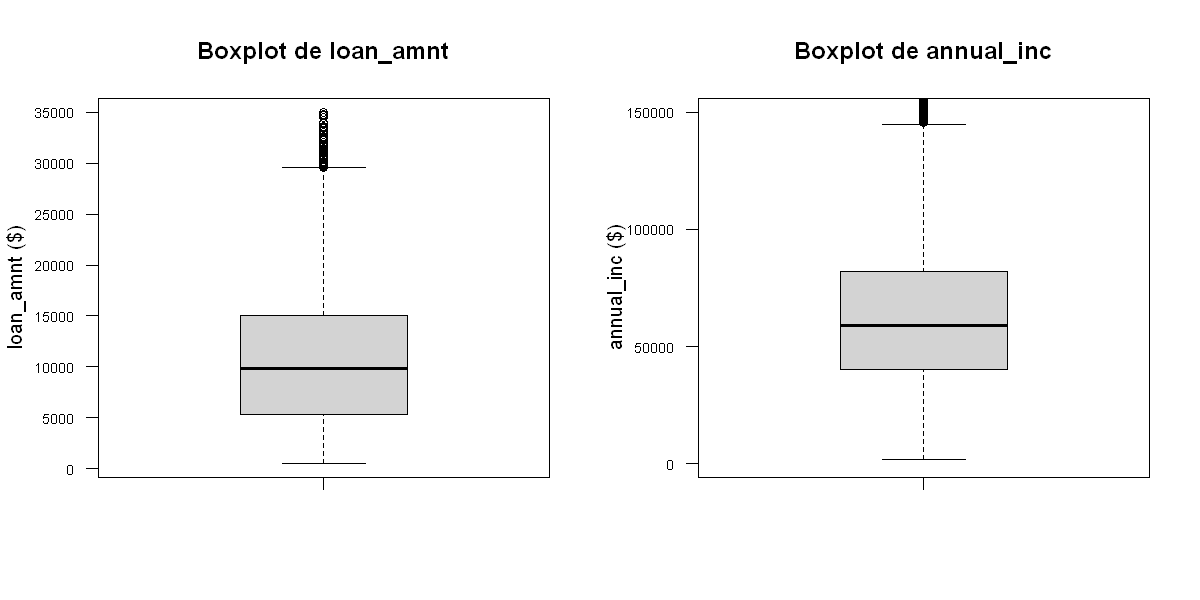

In [26]:
# Ajusto el tamaño de la ventana gráfica
options(repr.plot.width = 10, repr.plot.height = 5)

# Divido el área de gráficos en una disposición de 1 fila por 2 columnas
par(mfrow = c(1, 2))

# Creo el primer boxplot para loan_amnt
boxplot(loan_data$loan_amnt,
        main = "Boxplot de loan_amnt",
        ylab = "loan_amnt ($)",
        xlab = "",
        outline = TRUE,
        axes = FALSE)  # Oculto ejes para personalizarlos después

# Añado de nuevo los ejes
axis(2, las = 1, cex.axis = 0.7,
     at = pretty(loan_data$loan_amnt),
     labels = format(pretty(loan_data$loan_amnt), scientific = FALSE))
axis(1, at = 1, labels = "")
box()  # Añado el cuadro alrededor del gráfico

# Creo el segundo boxplot para annual_inc con rango limitado
boxplot(loan_data$annual_inc,
        main = "Boxplot de annual_inc",
        ylab = "annual_inc ($)",
        xlab = "",
        ylim = c(0, 150000),  # Limito el rango del eje y
        outline = TRUE,
        axes = FALSE)  # Oculto ejes para personalizarlos después

# Añado de nuevo los ejes
axis(2, las = 1, cex.axis = 0.7,
     at = pretty(loan_data$annual_inc[loan_data$annual_inc <= 150000]),
     labels = format(pretty(loan_data$annual_inc
                            [loan_data$annual_inc <= 150000]),
                     scientific = FALSE))
axis(1, at = 1, labels = "")
box()  # Añado el cuadro alrededor del gráfico


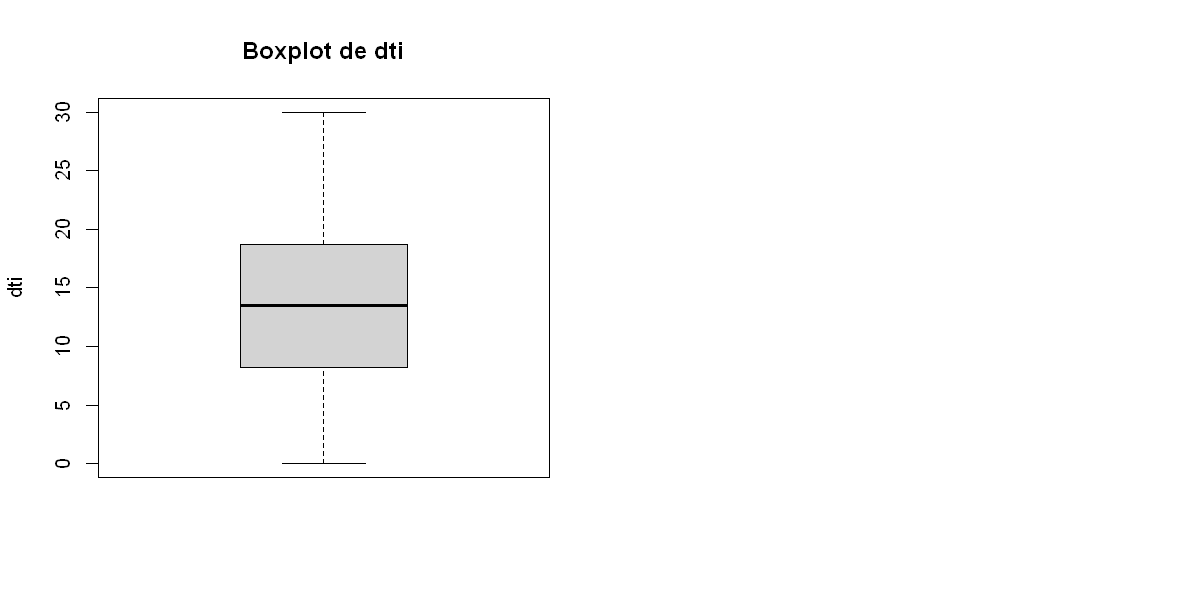

In [27]:
# Creo un boxplot para dti
par(mfrow = c(1, 2))  # Configuro el área de gráficos para un solo gráfico
boxplot(loan_data$dti,
        main = "Boxplot de dti",
        ylab = "dti",
        xlab = "",
        outline = TRUE)  # Mantengo los outliers

In [28]:
# Cálculo del rango intercuartílico de loan_amnt
q1 <- quantile(loan_data$loan_amnt, 0.25)
q3 <- quantile(loan_data$loan_amnt, 0.75)
iqr <- q3 - q1
lim_inf <- q1 - 1.5 * iqr
lim_sup <- q3 + 1.5 * iqr
# Identifico los outliers
outliers <- loan_data %>%
  filter(loan_amnt < lim_inf | loan_amnt > lim_sup)
# Número de outliers
nrow(outliers)

[1] 1111

In [29]:
# Cálculo del rango intercuartílico de annual_inc
q1 <- quantile(loan_data$annual_inc, 0.25)
q3 <- quantile(loan_data$annual_inc, 0.75)
iqr <- q3 - q1
lim_inf <- q1 - 1.5 * iqr
lim_sup <- q3 + 1.5 * iqr
# Identifico los outliers
outliers <- loan_data %>%
  filter(annual_inc < lim_inf | annual_inc > lim_sup)
# Número de outliers
nrow(outliers)

[1] 1838

In [30]:
#mediana y promedio de annual_inc
median(loan_data$annual_inc)
mean(loan_data$annual_inc)

[1] 58880

[1] 69057.61

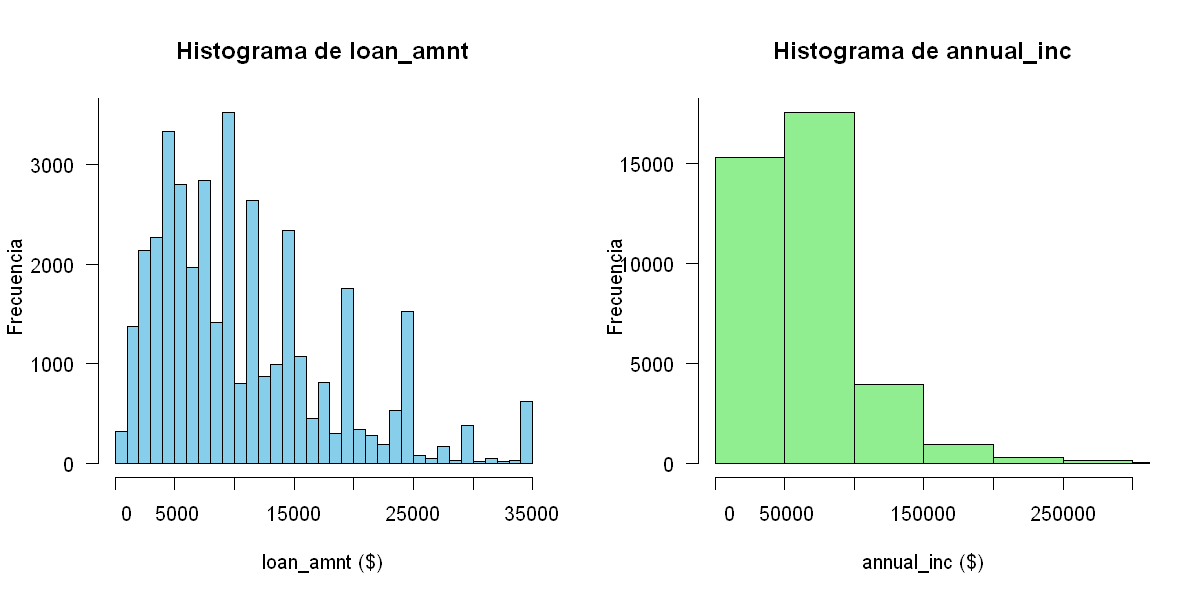

In [31]:
# Ajusto el tamaño de la ventana gráfica
options(repr.plot.width = 10, repr.plot.height = 5)

# Divido el área de gráficos en una disposición de 1 fila por 2 columnas
par(mfrow = c(1, 2))

# Creo el histograma para loan_amnt
hist(loan_data$loan_amnt,
     main = "Histograma de loan_amnt",
     xlab = "loan_amnt ($)",
     ylab = "Frecuencia",
     col = "skyblue",
     breaks = 30,  # Ajusto el número de bins
     axes = FALSE)  # Oculto ejes para personalizarlos después

# Añado los ejes personalizados para loan_amnt
axis(1, at = pretty(loan_data$loan_amnt),
     labels = format(pretty(loan_data$loan_amnt), scientific = FALSE))
axis(2, las = 1, at = pretty(range(hist(loan_data$loan_amnt, breaks = 30, plot = FALSE)$counts)))

# Creo el histograma para annual_inc con más bins
hist(loan_data$annual_inc,
     main = "Histograma de annual_inc",
     xlab = "annual_inc ($)",
     ylab = "Frecuencia",
     col = "lightgreen",
     breaks = 100,  # Incremento el número de bins
     xlim = c(0, 300000),  # Limito el rango del eje x
     axes = FALSE)  # Oculto ejes para personalizarlos después

# Añado los ejes personalizados para annual_inc
axis(1, at = pretty(loan_data$annual_inc[loan_data$annual_inc <= 300000]),
     labels = format(pretty(loan_data$annual_inc[loan_data$annual_inc <= 300000]), scientific = FALSE))
axis(2, las = 1, at = pretty(range(hist(loan_data$annual_inc, breaks = 100, plot = FALSE)$counts)))


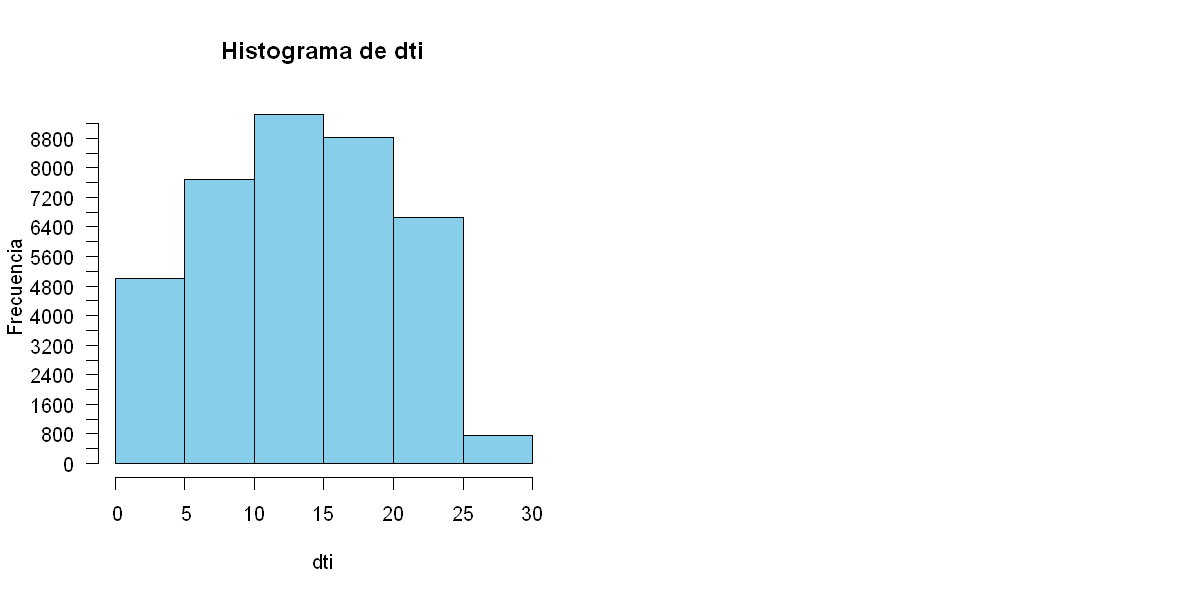

In [32]:
# Configuro el área de gráficos para un solo gráfico
par(mfrow = c(1, 2))
# Obtengo las frecuencias del histograma de dti sin dibujarlo
hist_info_dti <- hist(loan_data$dti, breaks = 10, plot = FALSE)

# Calculo la frecuencia máxima para dti
max_freq_dti <- max(hist_info_dti$counts)

# Creo el histograma para dti con el ajuste del eje y
hist(loan_data$dti,
     main = "Histograma de dti",
     xlab = "dti",
     ylab = "Frecuencia",
     col = "skyblue",
     breaks = 10,
     ylim = c(0, max_freq_dti + 50),  # Ajusto el rango del eje y
     axes = FALSE)  # Oculto ejes para personalizarlos después

# Añado los ejes personalizados para dti
axis(1, at = hist_info_dti$breaks, labels =
       format(hist_info_dti$breaks, scientific = FALSE))
axis(2, las = 1, at = seq(0, max_freq_dti + 50, by = 400))

In [33]:
# Varianza y desviación estándar de loan_amnt
var_loan_amnt <- var(loan_data$loan_amnt)
sd_loan_amnt <- sd(loan_data$loan_amnt)
var_loan_amnt
sd_loan_amnt

[1] 54811627

[1] 7403.487

In [34]:
# Varianza y desviación estándar de annual_inc
var_annual_inc <- var(loan_data$annual_inc)
sd_annual_inc <- sd(loan_data$annual_inc)
var_annual_inc
sd_annual_inc

[1] 4160751266

[1] 64503.89

In [35]:
# Varianza y desviación estándar de dti
var_dti <- var(loan_data$dti)
sd_dti <- sd(loan_data$dti)
var_dti
sd_dti

[1] 45.25706

[1] 6.727337

Analisis Univariado Variables Categoricas Seleccionadas

Considero que las variables categoricas más importantes son 2: repay_fail y term

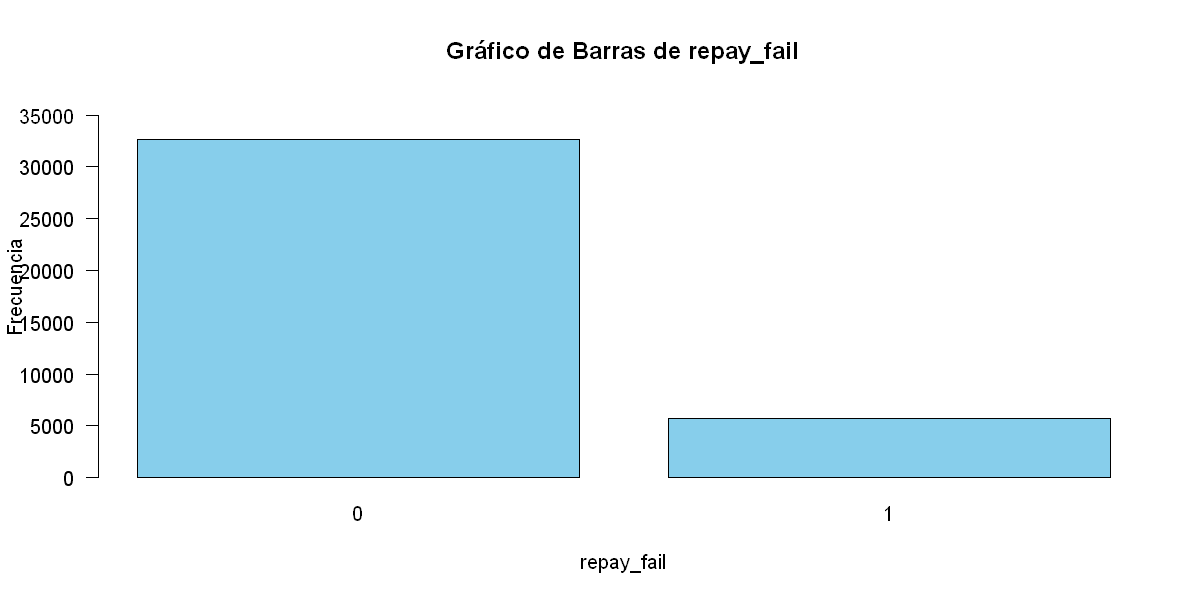

In [36]:
# Creo la tabla de frecuencias para repay_fail
freq_table_repay_fail <- table(loan_data$repay_fail)

# Creo el gráfico de barras
barplot(freq_table_repay_fail,
        main = "Gráfico de Barras de repay_fail",
        xlab = "repay_fail",
        ylab = "Frecuencia",
        col = "skyblue",
        ylim = c(0, max(freq_table_repay_fail) + 4000),
        las = 1)  # Hacer que las etiquetas del eje y sean horizontales

# Añado más etiquetas en el eje y
y_ticks <- seq(0, max(freq_table_repay_fail) + 50, by = 5000)
axis(2, at = y_ticks, labels = y_ticks, las = 1)

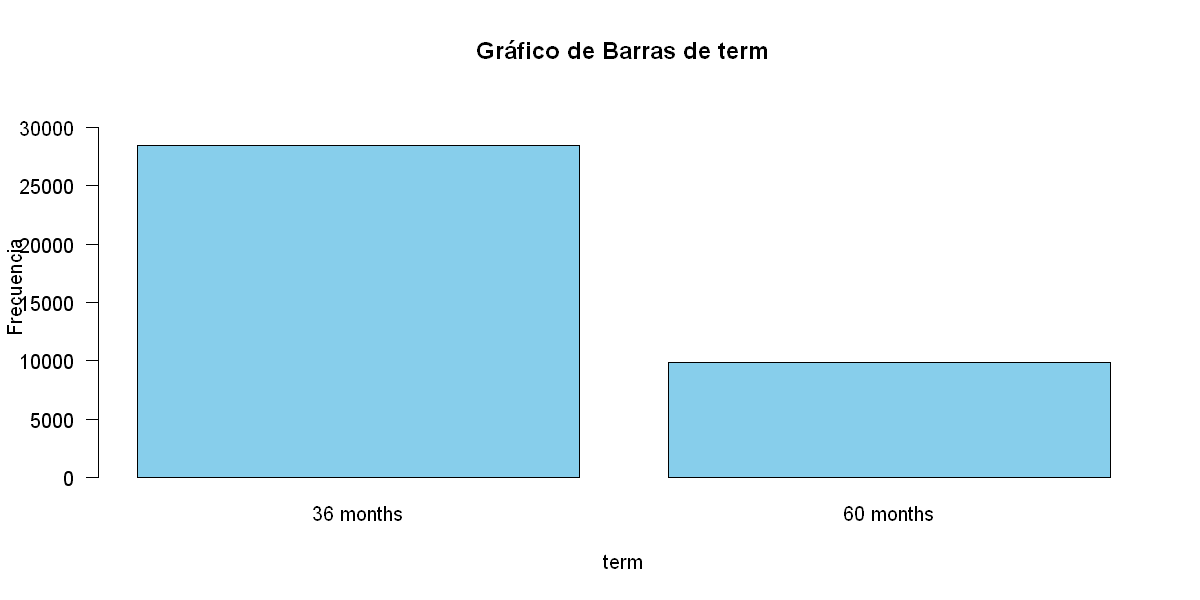

In [37]:
# Creo la tabla de frecuencias para term
freq_table_term <- table(loan_data$term)

# Creo el gráfico de barras
barplot(freq_table_term,
        main = "Gráfico de Barras de term",
        xlab = "term",
        ylab = "Frecuencia",
        col = "skyblue",
        ylim = c(0, max(freq_table_term) + 4000),
        las = 1)  # Hago que las etiquetas del eje y sean horizontales

# Añado más etiquetas en el eje y
y_ticks <- seq(0, max(freq_table_term) + 50, by = 5000)
axis(2, at = y_ticks, labels = y_ticks, las = 1)

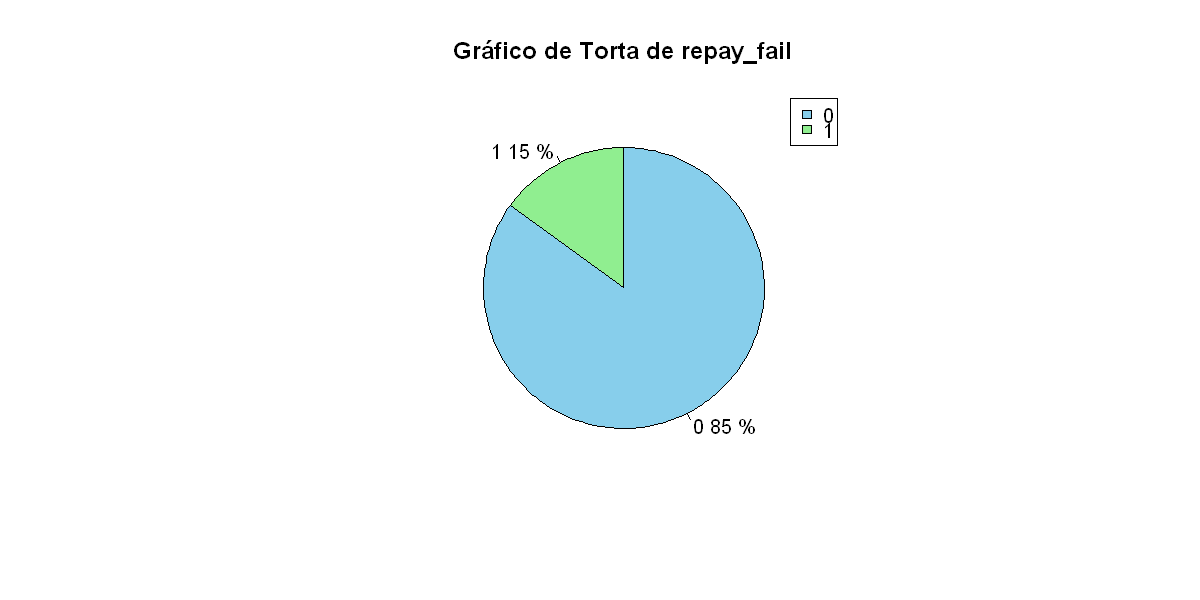

In [38]:
# Creo la tabla de frecuencias para repay_fail
freq_table_repay_fail <- table(loan_data$repay_fail)

# Calculo los porcentajes
percentages <- round(100 * freq_table_repay_fail / sum(freq_table_repay_fail), 1)
labels <- paste(names(freq_table_repay_fail), percentages, "%")

# Creo el gráfico de torta
pie(freq_table_repay_fail,
    main = "Gráfico de Torta de repay_fail",
    col = c("skyblue", "lightgreen"),
    labels = labels,
    clockwise = TRUE)

# Añado leyenda
legend("topright", legend = names(freq_table_repay_fail), fill = c("skyblue", "lightgreen"))


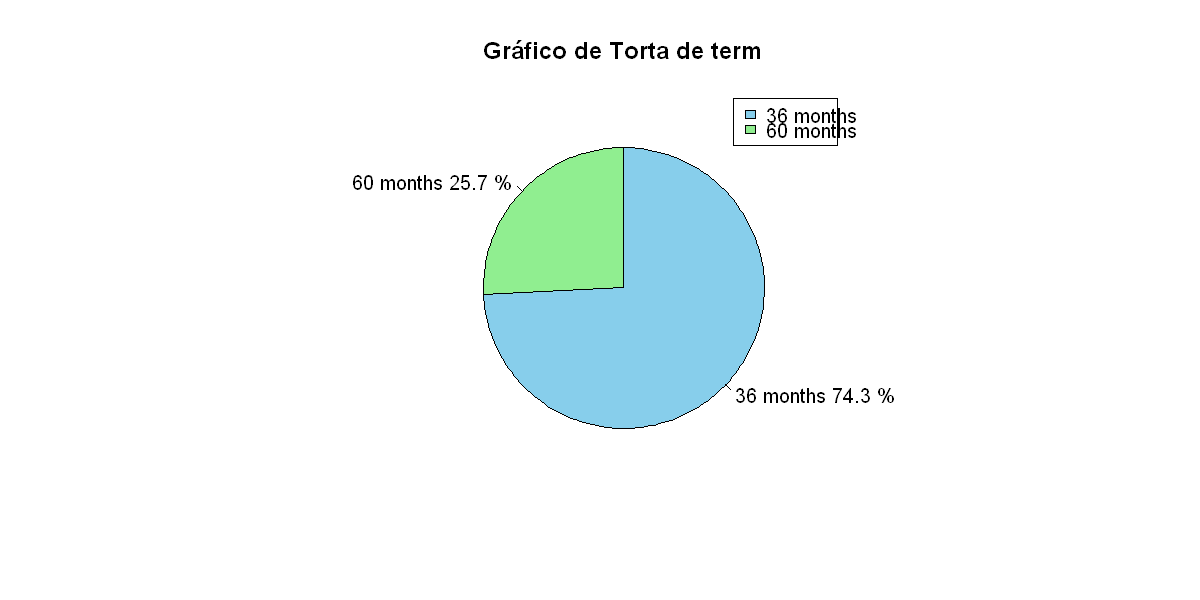

In [39]:
# Creo la tabla de frecuencias para term
freq_table_term <- table(loan_data$term)

# Calculo los porcentajes
percentages <- round(100 * freq_table_term / sum(freq_table_term), 1)
labels <- paste(names(freq_table_term), percentages, "%")

# Creo el gráfico de torta
pie(freq_table_term,
    main = "Gráfico de Torta de term",
    col = c("skyblue", "lightgreen"),
    labels = labels,
    clockwise = TRUE)

# Añado leyenda
legend("topright", legend = names(freq_table_term), fill = c("skyblue", "lightgreen"))


In [40]:
## Creo la tabla de frecuencias para repay_fail
freq_table_repay_fail <- table(loan_data$repay_fail)
freq_table_repay_fail


    0     1 
32606  5739 

In [41]:
## Creo la tabla de frecuencias para term
freq_table_term <- table(loan_data$term)
freq_table_term


36 months 60 months 
    28478      9867 

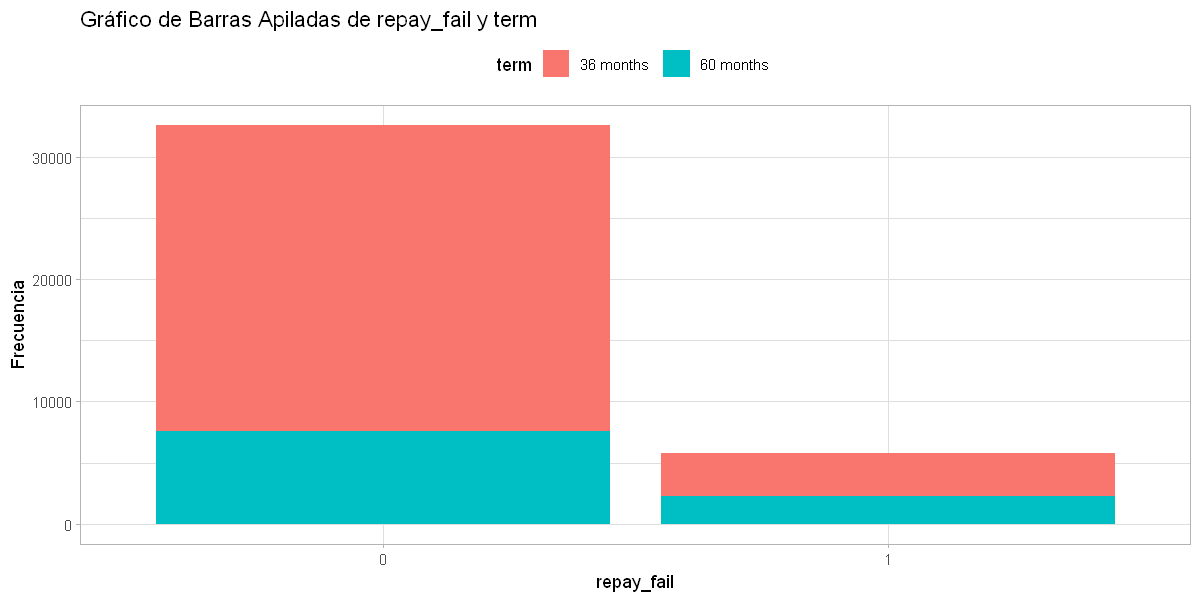

In [42]:
# Creo el gráfico de barras apiladas usando ggplot2
# para las variables repay_fail y purpose
ggplot(loan_data, aes(x = factor(repay_fail), fill = factor(term))) +
  geom_bar(position = "stack") +
  labs(title = "Gráfico de Barras Apiladas de repay_fail y term",
       x = "repay_fail",
       y = "Frecuencia",
       fill = "term") +
  theme_light() +
  theme(legend.position = "top")

La siguiente celda tiene como objetivo calcular la correlación biserial entre las variables numéricas de un conjunto de datos y la variable de interés (repay_fail), y luego visualizar estas correlaciones utilizando un heatmap.

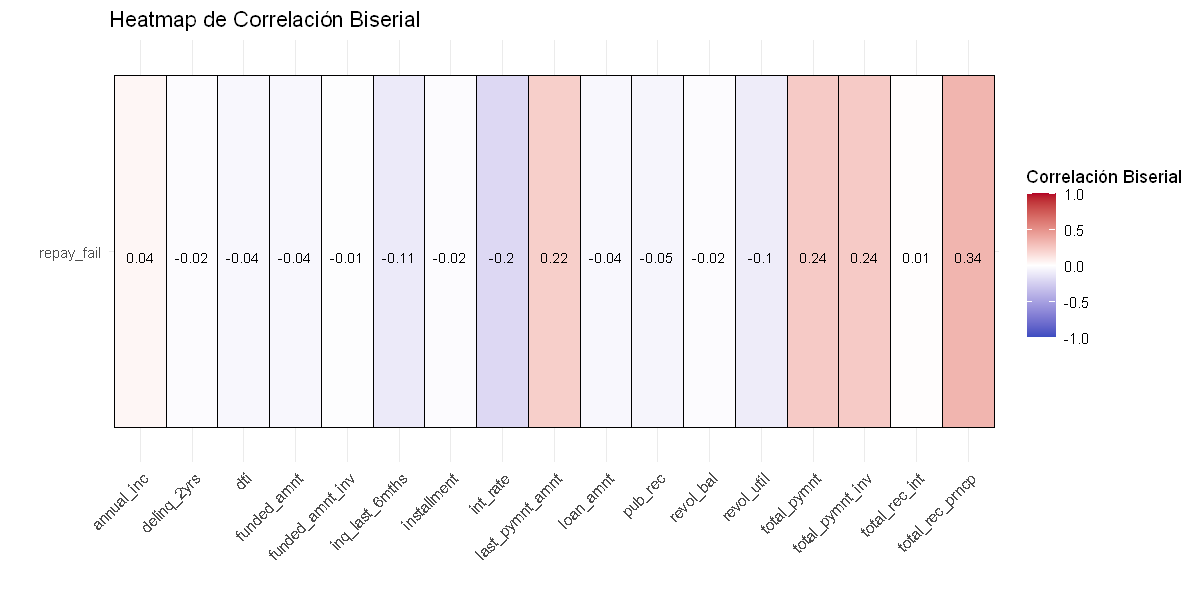

In [43]:
# Selecciono solo las columnas numéricas
numeric_vars <- sapply(loan_data, is.numeric)
datos_numericos <- loan_data[, numeric_vars]

# Añado 'repay_fail' a los datos numéricos
datos_numericos$repay_fail <- loan_data$repay_fail

# creo función para calcular la correlación biserial
cor_biserial <- function(x, y) {
  biserial.cor(x, y)
}

# Calculo la correlación biserial entre cada variable numérica y 'repay_fail'
correlaciones <- sapply(datos_numericos[, -ncol(datos_numericos)], cor_biserial, y = datos_numericos$repay_fail)

# Convierto las correlaciones a un data frame para ggplot
correlaciones_df <- data.frame(Variable = names(correlaciones), Correlacion = correlaciones)

# Ajusto tamaño de etiquetas para mejorar la visualización
correlaciones_df$Correlacion <- round(correlaciones_df$Correlacion, 2)

# Creo el heatmap con etiquetas mejoradas
ggplot(correlaciones_df, aes(x = Variable, y = "repay_fail", fill = Correlacion)) +
  geom_tile(color = "black") +
  geom_text(aes(label = Correlacion), vjust = 1, color = "black", size = 3) +
  scale_fill_gradient2(low = "#3B4CC0", mid = "#FFFFFF", high = "#B40426", 
                       midpoint = 0, limit = c(-1, 1), space = "Lab", 
                       name = "Correlación Biserial") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "", y = "", title = "Heatmap de Correlación Biserial")

Propósito y Utilidad

El propósito del código es identificar qué variables numéricas tienen una relación significativa con la variable repay_fail. Esta información es crucial para:

Selección de Características:

Identificar las variables más relevantes para incluir en el modelo de Naive Bayes.

Preprocesamiento:

Determinar qué variables podrían necesitar transformaciones adicionales (como binning) antes de ser utilizadas en el modelo.

La siguiente celda se encarga de eliminar las variables que tienen una baja correlación con la variable objetivo repay_fail.

In [44]:
#por ende procedo a eliminar las variables que tienen baja
# correlación con la variable objetivo
#osea elimino funded_amnt_inv, installment, revol_bal, total_rec_int
# delinq_2yrs, funded_amnt, pub_rec, inq_last_6mths, loan_amnt, revol_util
loan_data <- loan_data %>%
  dplyr::select(-funded_amnt_inv, -installment, -revol_bal,
                -total_rec_int, -delinq_2yrs, -funded_amnt, -pub_rec,
                -inq_last_6mths, -loan_amnt, -revol_util)

Este paso se enfoca en eliminar variables que no aportan información significativa en relación con la variable objetivo repay_fail. Reducir el número de variables simplifica el modelo y mejora su rendimiento, evitando el sobreajuste.

Mejora en la Eficiencia del Modelo:

Al eliminar las variables irrelevantes, el modelo de Naive Bayes podrá centrarse en las variables que realmente tienen una influencia significativa en la predicción de repay_fail.

In [46]:
#creo 2 copias de loan_data, una para el modelo de
# k-NN de clasificación y otra para el modelo de naives bayes
loan_data_knn <- loan_data
loan_data2 <- loan_data